In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization
import decimal

In [2]:
ftrainpath = "archive/seg_train/seg_train"
ftestpath = "archive/seg_test/seg_test"
random_seed = 23

traintypes = os.listdir(ftrainpath)
print("Number of Types:", len(traintypes))
testtypes = os.listdir(ftestpath)

Number of Types: 6


In [3]:
def label(types, fpath):
    img_lst=[]
    labels=[]
    for index, category in enumerate(types):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = Image.fromarray(img, 'RGB')
            resized_img = img_array.resize((256, 256))
            img_lst.append(np.array(resized_img))
            labels.append(index)
    return img_lst, labels

trainimages, trainlabels = label(traintypes, ftrainpath)
testimages, testlabels = label(testtypes, ftestpath)
print("No. of Train images:",len(trainimages),"\nNo. of Train labels:",len(trainlabels))
print("No. of Test images:",len(testimages),"\nNo. of Test labels:",len(testlabels))

No. of Train images: 14034 
No. of Train labels: 14034
No. of Test images: 3000 
No. of Test labels: 3000


In [4]:
trainimages = np.array(trainimages)
trainlabels = np.array(trainlabels)
testimages = np.array(testimages)
testlabels = np.array(testlabels)
print("Train Images shape = ",trainimages.shape,"\nTrain Labels shape = ",trainlabels.shape)
print("Test Images shape = ",testimages.shape,"\nTest Labels shape = ",testlabels.shape)

Train Images shape =  (14034, 256, 256, 3) 
Train Labels shape =  (14034,)
Test Images shape =  (3000, 256, 256, 3) 
Test Labels shape =  (3000,)


In [5]:
def printer(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(8):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        plt.subplot(2 , 4 , n)
        plt.subplots_adjust(hspace = 0.1 , wspace = 0.1)
        plt.imshow(images[r[0]])
        if labels[r[0]] == 0:
            plt.title('Type: Buildings')
        elif labels[r[0]] == 1:
            plt.title('Type: Forest')
        elif labels[r[0]] == 2:
            plt.title('Type: Glacier')
        elif labels[r[0]] == 3:
            plt.title('Type: Mountain')
        elif labels[r[0]] == 4:
            plt.title('Type: Sea')
        elif labels[r[0]] == 5:
            plt.title('Type: Street')    
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

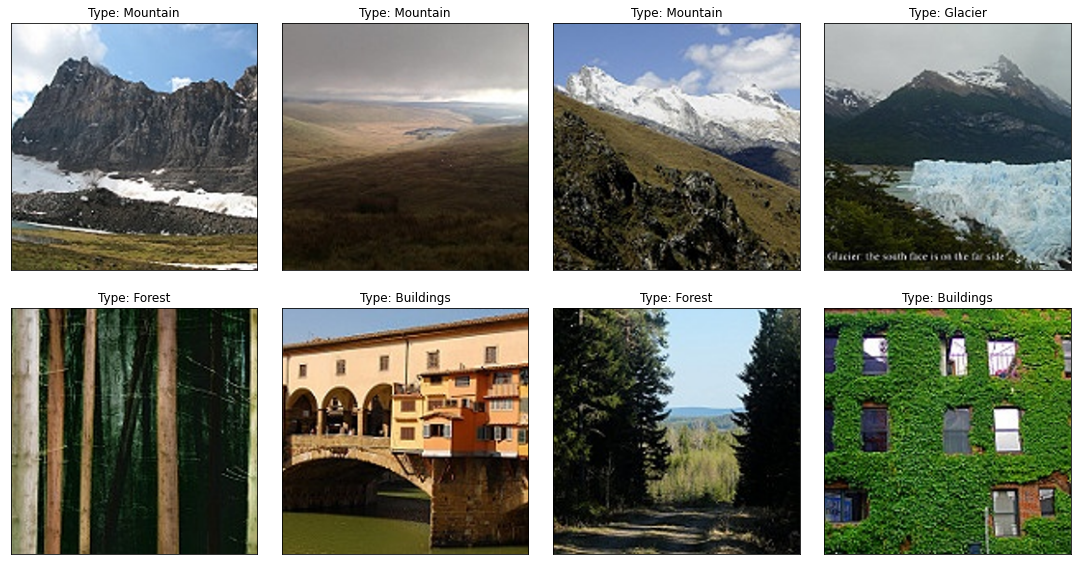

In [6]:
printer(trainimages, trainlabels)

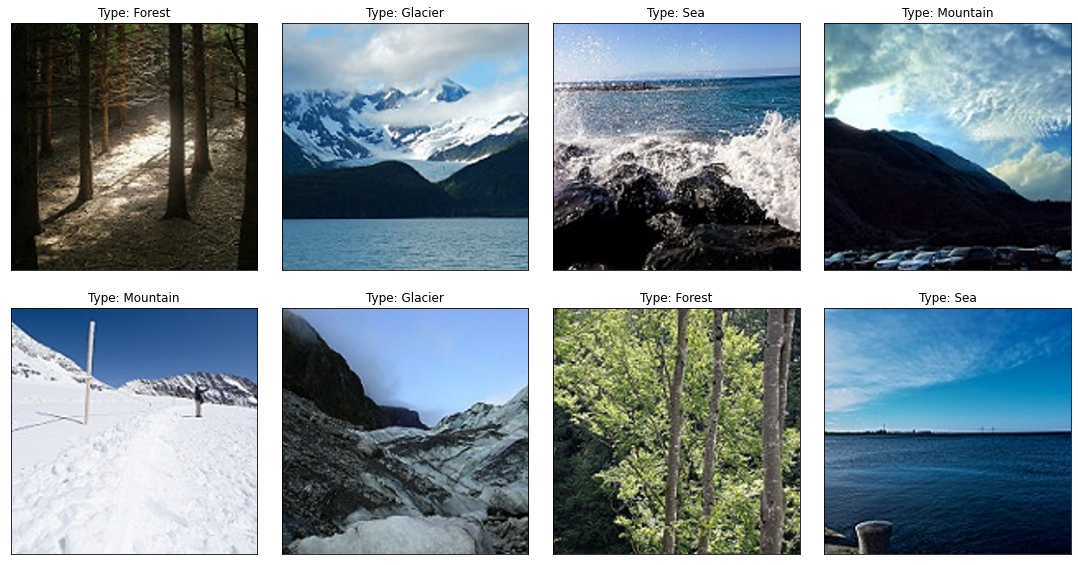

In [7]:
printer(testimages, testlabels)

In [8]:
train_n = np.arange(trainimages.shape[0])
test_n = np.arange(testimages.shape[0])
np.random.seed(random_seed)
np.random.shuffle(train_n)
np.random.shuffle(test_n)
images = trainimages[train_n]
labels = trainlabels[train_n]
images = testimages[test_n]
labels = testlabels[test_n]

In [9]:
x_train, x_test, y_train, y_test = trainimages, testimages, trainlabels, testlabels
print("x_train shape:",x_train.shape)
print("y_train shape:",y_train.shape)
print("x_test shape:",x_test.shape)
print("y_test shape:",y_test.shape)

x_train shape: (14034, 256, 256, 3)
y_train shape: (14034,)
x_test shape: (3000, 256, 256, 3)
y_test shape: (3000,)


In [10]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(256,256,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(256,256,3),activation="relu"))


model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))


model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))


model.add(BatchNormalization())

#output layer
model.add(Dense(20,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 384)       8

In [11]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [12]:
%%time
model.fit(x_train, y_train, epochs=3)

Epoch 1/3
439/439 [==============================] - 496s 1s/step - loss: 1.4411 - accuracy: 0.5078
Epoch 2/3
439/439 [==============================] - 507s 1s/step - loss: 1.0087 - accuracy: 0.6202
Epoch 3/3
439/439 [==============================] - 513s 1s/step - loss: 0.8677 - accuracy: 0.6779
Wall time: 25min 32s


In [13]:
loss, accuracy = model.evaluate(x_test, y_test)

94/94 [==============================] - 25s 265ms/step - loss: 1.1393 - accuracy: 0.6153
